In [1]:
import os
import torch
import numpy as np

print(os.sys.path)
os.sys.path.append("/home/matthias/DIKU Project Protein Folding/protein-folding-gans/src/openprotein/pnerf")

# CODE FILES HERE
from model_params import get_model_data_dcgan
from models.dcgan import Dcgan, Generator, Discriminator
from solver import Solver, Testing
from directories import Directories
from dataloader import DataLoader
from plots import plot_losses, plot_z_samples, plot_grid
from sampling import dcgan_sampling, generate_latent_points, interpolate_points, find_closest_gt
from contact_maps import get_contact_maps
import preprocessing

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

['/home/matthias/DIKU Project Protein Folding/protein-folding-gans/src', '/home/matthias/.local/share/virtualenvs/openprotein-xj-YAKcS/lib/python37.zip', '/home/matthias/.local/share/virtualenvs/openprotein-xj-YAKcS/lib/python3.7', '/home/matthias/.local/share/virtualenvs/openprotein-xj-YAKcS/lib/python3.7/lib-dynload', '/home/matthias/anaconda3/envs/openprotein/lib/python3.7', '', '/home/matthias/.local/share/virtualenvs/openprotein-xj-YAKcS/lib/python3.7/site-packages', '/home/matthias/.local/share/virtualenvs/openprotein-xj-YAKcS/lib/python3.7/site-packages/IPython/extensions', '/home/matthias/.ipython']


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Preprocessing from raw files to actual hd5 files
dataset_arg = "proteins"
prefix = "_max_length/"
data_root_folder = "../data/proteins/"
data = get_model_data_dcgan(dataset_arg)

residue_fragments = 128
preprocessing.MAX_SEQUENCE_LENGTH = 2000

preprocessing.process_raw_data(False, force_pre_processing_overwrite=False, prefix=prefix,
                               data_root_folder=data_root_folder)

Starting pre-processing of raw data...
files ['../data/proteins/raw/training_50.txt', '../data/proteins/raw/training_95.txt', '../data/proteins/raw/training_100.txt', '../data/proteins/raw/validation', '../data/proteins/raw/testing.txt', '../data/proteins/raw/sample.txt', '../data/proteins/raw/training_70.txt', '../data/proteins/raw/training_90.txt', '../data/proteins/raw/training_30.txt']
Preprocessed file for training_50.txt already exists.
Skipping pre-processing for this file...
Preprocessed file for training_95.txt already exists.
Skipping pre-processing for this file...
Preprocessed file for training_100.txt already exists.
Skipping pre-processing for this file...
Preprocessed file for validation already exists.
Skipping pre-processing for this file...
Preprocessed file for testing.txt already exists.
Skipping pre-processing for this file...
Preprocessed file for sample.txt already exists.
Skipping pre-processing for this file...
Preprocessed file for training_70.txt already exis

In [4]:
train_file_name = "testing"
training_file = data_root_folder+"preprocessed/" + str(preprocessing.MAX_SEQUENCE_LENGTH)\
            + prefix + train_file_name + ".txt.hdf5"
print("training file: {0}".format(training_file))
padding = "pwd_pad"
print("padding: {}".format(padding))

training file: ../data/proteins/preprocessed/2000_max_length/testing.txt.hdf5
padding: pwd_pad


In [5]:
directories = Directories("dcgan", dataset_arg.lower(), data["z_dim"], make_dirs=True)
data_loader = DataLoader(directories, data["batch_size"], dataset_arg.lower(),
                         training_file=training_file, residue_fragments=residue_fragments,
                         atom="calpha", padding=padding)

Reading cache file in ../data/proteins/preprocessed/2000_max_length/testing_128_pwd_pad_contact_maps.dat
(128, 128) 16384 17 17 129


Reading cache file in ../data/proteins/preprocessed/2000_max_length/testing_128_pwd_pad_contact_maps.dat
torch.Size([129, 1, 128, 128])


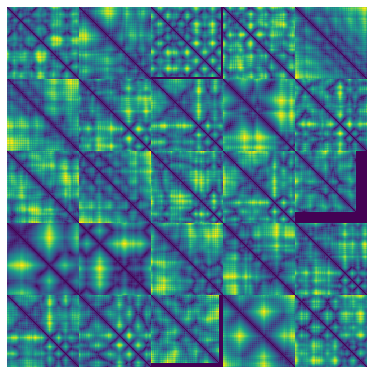

In [6]:
# show ground truth contact maps
samples = get_contact_maps(training_file, fragment_length=residue_fragments, padding=padding).unsqueeze(1)
print(samples.shape)
samples = samples[0:25]
plot_grid(samples, None, nrow=5, ncol=5)

In [ ]:
# train model
dcgan = Dcgan(data_loader.input_dim, data["z_dim"])
generator = Generator(data["z_dim"], res=residue_fragments)
discriminator = Discriminator(1, 1, res=residue_fragments)
solver = Solver(dcgan, generator, discriminator, data["epochs"], data_loader, data["optimizer_G"],
                data["optimizer_D"], data["optim_config_G"], data["optim_config_D"],
                preprocessing.MAX_SEQUENCE_LENGTH, data["one_sided_labeling"], data["g_updates"],
                save_model_state=False)
solver.main()

+++++ START RUN | saved files in dcgan/proteins_z=100_85 +++++
params used:
 epochs: 50
dim(z): 100
batch_size: 8
optimizer_G: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0
)
optimizer_D: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0
)
dataset: proteins
img dims: (128, 128)
atom: calpha
Max sequence length: 2000
training file: ../data/proteins/preprocessed/2000_max_length/testing.txt.hdf5
padding: pwd_pad
g_updates: 2
one_sided_labeling: 1.0
Dcgan(
  (loss): BCELoss()
)Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

In [ ]:
# test complexity of model as in A.4
test_file_name = "testing"
testing_file = data_root_folder+"preprocessed/" + str(preprocessing.MAX_SEQUENCE_LENGTH)\
             + prefix + test_file_name + ".txt.hdf5"
print("testing file: {0}".format(testing_file))
optim_config_G = {
    "lr": 1e-2,
    "weight_decay": None,
    "betas": (0.5, 0.999)
}
optimizer_G = torch.optim.Adam(generator.parameters(), **optim_config_G)
testing = Testing(solver)
test_loader = solver.data_loader.get_new_test_data_loader(testing_file=testing_file)
testing.test(optimizer_G, test_loader)

In [ ]:
# Insert name of model here if want to load a model
LOAD_MODEL = 1
if LOAD_MODEL:
    res_dir = "../../results/"
    solver = torch.load(res_dir+"256_64_18_50.pt", map_location="cpu")
    generator = solver.generator
    discriminator = solver.discriminator
    generator.eval()
    discriminator.eval()
    solver.data_loader.directories.make_dirs = False
else:
    res_dir = solver.data_loader.directories.result_dir

In [ ]:
# Plotting g and d losses for all epochs
plot_losses(solver, solver.train_loss_history["g_loss"], solver.train_loss_history["d_loss"])

In [ ]:
# sampling a grid of distance maps
samples = dcgan_sampling(generator, solver.model.z_dim, 25).detach().numpy()
imgs, rows, cols = solver.get_sample_stats()
plot_grid(samples[:imgs], res_dir+"/plot_grid.png", nrow=rows, ncol=cols)

In [ ]:
del imgs
del samples

In [ ]:
# generate points in latent space
pts = generate_latent_points(solver.model.z_dim, 2)
# interpolate points in latent space
zs = interpolate_points(pts[0], pts[1])
samples = generator(zs).detach().numpy()
imgs, rows, cols = solver.get_sample_stats()
plot_grid(samples[:imgs], res_dir+"/plot_linear_interpolation.png", 1, 8)

In [ ]:
del pts
del zs
del samples

In [ ]:
# load the ground truth data set
max_len = 256
train_file_name = "training_95"
training_file = "../data/proteins/"+"preprocessed/" + str(max_len)\
                + "_max_length/" + train_file_name + ".txt.hdf5"
print(training_file)
test_loader = solver.data_loader.get_new_test_data_loader(testing_file=training_file, batch_size=1)
# find closest ground truth
min_loss_maps = find_closest_gt(generator, solver.model.z_dim, test_loader)

In [ ]:
imgs, rows, cols = solver.get_sample_stats()
gens = torch.FloatTensor([x[2] for x in min_loss_maps[:imgs]])
gt_maps = [x[3] for x in min_loss_maps[:imgs]]
gt_maps = torch.cat(gt_maps).unsqueeze(1)
losses = [x[1] for x in min_loss_maps[:imgs]]
print("Losses: {}".format(losses))
l2_losses = [x[1] for x in min_loss_maps]
print("L2 map error {} {}".format(sum(l2_losses), sum(l2_losses)/len(l2_losses)))
asd = torch.cat([gens, gt_maps])
plot_grid(asd, res_dir+"/_plot_" + sum(l2_losses) + "_comparison.png")

In [ ]:
del test_loader
del min_loss_maps
del gens
del gt_maps